Importing Dependencies

In [1]:
from re import I
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [7]:
#Loading the data
df = pd.read_csv('/content/Reviews.csv')

In [8]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [9]:
#Scaling down the dataset to 700 rows
df = df.head(700)
df.shape

(700, 10)

Exploration analysis

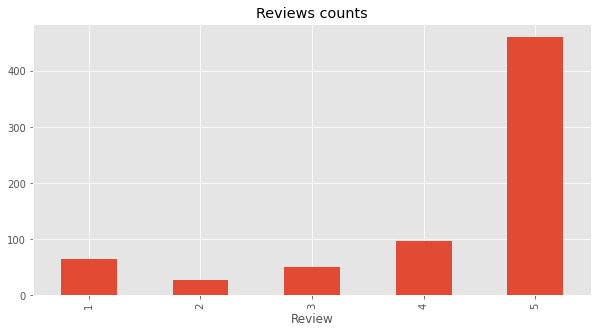

In [15]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Reviews counts',figsize=(10,5))
ax.set_xlabel('Review')
plt.show()


Basic NLTK workflow

In [16]:
# sammple sentiment
sample = df['Text'][50]
sample

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [ ]:
nltk.download('all')

In [20]:
#nltk tokenization
tokens = nltk.word_tokenize(sample)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [25]:
#finding part of speech for these words
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [28]:
# allocating entities
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Vander Sentiment scoring
> Here I will use nltk sentimentintensityanalyzer to get the neg|neu||pos scores of the text

> A bag of words is used in this approach where
 * stops words are removed
 *each word is scored and combined to atotal score

In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm #progress bar tracker

sentiment = SentimentIntensityAnalyzer()


In [30]:
#running an example
sentiment.polarity_scores('I am sad')

{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}

In [31]:
sentiment.polarity_scores('This is the best day of my life')

{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.6369}

In [32]:
sentiment.polarity_scores(sample)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [39]:
# Running polarity score on the entire dataset
import time
from tqdm.notebook import tqdm

results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  myid = row['Id']
  results[myid] = sentiment.polarity_scores(text)
  


  0%|          | 0/700 [00:00<?, ?it/s]

In [44]:
#saving results in a dataframe
vanders = pd.DataFrame(results).T
vanders = vanders.reset_index().rename(columns={'index':'Id'})
vanders = vanders.merge(df, how='left')

In [47]:
vanders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Plotting vanders score

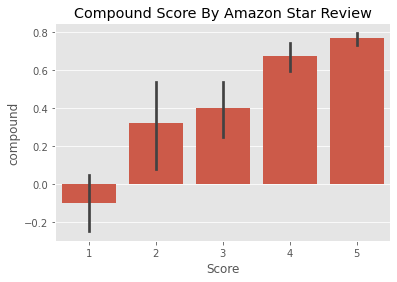

In [50]:
base_color = sns.color_palette()[0]
ax = sns.barplot(data=vanders, x='Score', y='compound', color=base_color )
ax.set_title('Compound Score By Amazon Star Review')
plt.show()

From the Above visual it evident that the higher the score given the more positive compound score of text is 

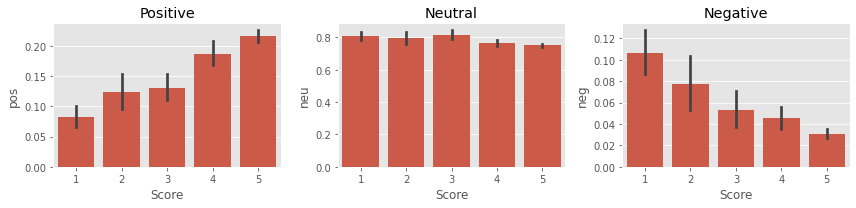

In [55]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=vanders, x='Score', y='pos',color=base_color, ax=axs[0])
sns.barplot(data=vanders, x='Score', y='neu',color=base_color, ax=axs[1])
sns.barplot(data=vanders, x='Score', y='neg',color=base_color, ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Roberta Pretrained Model
* This is use of model trained of a large corpus of data
* It accounts for the words and also the context related to other words

In [56]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 2.1 MB/s 
     |████████████████████████████████| 6.6 MB 37.9 MB/s 
     |████████████████████████████████| 120 kB 70.8 MB/s 


In [57]:
from transformers import AutoTokenizer 
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [58]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [61]:
# Running text on roberta model
encoded_text = tokenizer(sample, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
scores_dict

{'roberta_neg': 0.9763551,
 'roberta_neu': 0.020687476,
 'roberta_pos': 0.0029573715}

In [62]:
#running on the whole notebook
def polarity_scores_roberta(sample):
  encoded_text = tokenizer(sample, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
  }
  return scores_dict

In [71]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vander_result = sentiment.polarity_scores(text)
    vander_result_rename = {}
    for key, value in vander_result.items():
      vander_result_rename[f"vander_{key}"] = value
      
    roberta_results = polarity_scores_roberta(text)
    both = {**vander_result_rename, **roberta_results}
    results[myid] = both
  except RuntimeError:
    print(f'Broke for id {myid}')

  0%|          | 0/700 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540


In [68]:
both

{'vander_neg': 0.0,
 'vander_neu': 0.695,
 'vander_pos': 0.305,
 'vander_compound': 0.9441,
 'roberta_neg': 0.009624219,
 'roberta_neu': 0.049980354,
 'roberta_pos': 0.9403955}

In [75]:
#saving results in a dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')

## Comparison of scores between models

In [76]:
results_df.columns

Index(['Id', 'vander_neg', 'vander_neu', 'vander_pos', 'vander_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

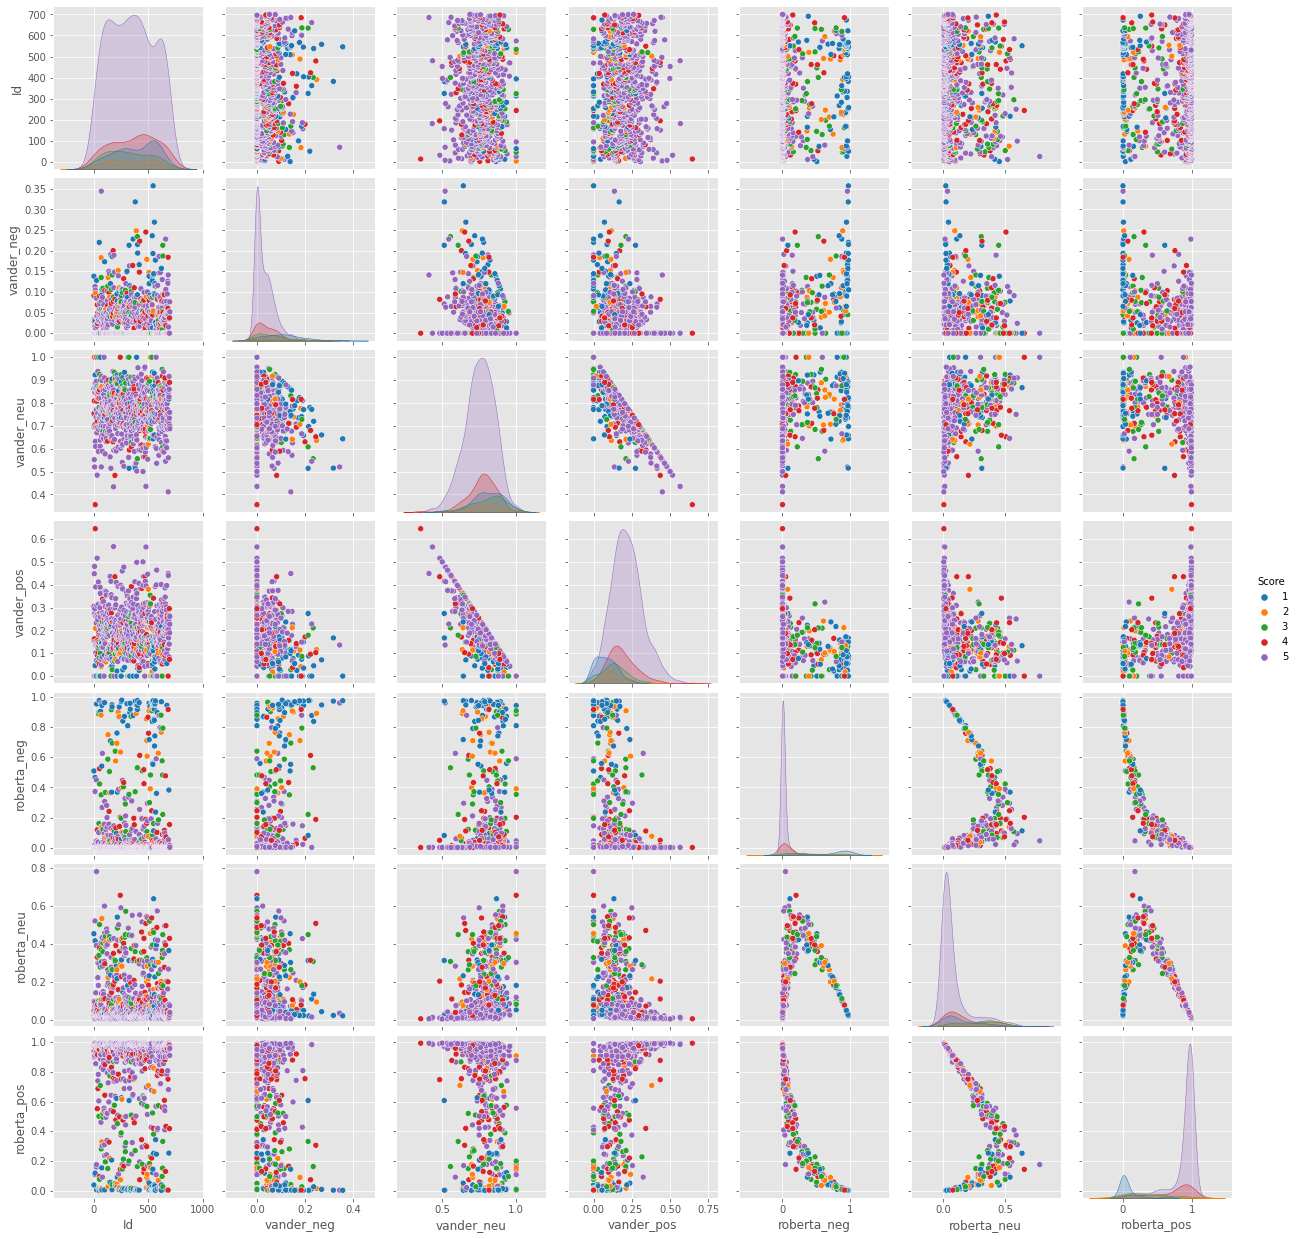

In [79]:
sns.pairplot(data=results_df,
             vars=['Id', 'vander_neg', 'vander_neu', 'vander_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()


## Exampples reviews
* where the model scoring and reviewscore differ most
* both positive and negative review

In [80]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [81]:
results_df.query('Score == 1').sort_values('vander_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [82]:
# Negative sentiment 5 star review
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [84]:
results_df.query('Score == 5').sort_values('vander_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Transformers Pipeline

In [85]:
from transformers import pipeline

sentiment_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [88]:
# Testing
sentiment_pipeline('I love gym')

[{'label': 'POSITIVE', 'score': 0.9996960163116455}]

By *MutegiMk* and credits to *Medallion*